## Machine Learning for Credit Card Fraud Detection

## Introduction
Credit card fraud can result in significant financial losses for individuals, businesses, and financial institutions. Detecting fraudulent transactions early allows for prompt action to minimize financial damage and prevent unauthorized charges from being processed.

## Goals
In this jupyter notebook, we will apply unsupervised and supervised machine learning techniques to detect fraud transactions. Specifically:
- For unsupervised learning:
    - We will perform dimension reduction with three different techniques (TSNE, PCA, TruncatedSVD) to reduce the data representation to lower dimensions.
    - Then by visualizing data in the new lower feature space, we will identify clusters of fraud transactions.
- For supervised learning:
    - We will train a binary classifier to predict whether a transaction is fraud or not.
    - We will experiment with a LogisticRegression classifier and a DecisionTree classifier, and compare their performance.
    - By interpreting feature coefficients, we will extract features that are predictive of fraud transactions.


## Data Overview
The [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) contains 284,807 credit card transactions by European cardholders in September 2013 (492 fraud transactions and 284,315 non-fraud transactions).

Each transation has a target variable 'Class', indicating whether it is fraud (value 1) or not (value 0).

Each transaction is represented by 30 features:
- 28 numerical features (V1, V2, … V28) obtained from a PCA transformation (Dimensionality Reduction technique). Due to confidentiality issues, the original features before PCA transformation are not provided.
- feature 'Time' (the seconds elapsed between each transaction and the first transaction)
- feature 'Amount' (the transaction amount).


## References
- [Machine learning for credit card fraud detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/MachineLearningForFraudDetection.html)
- [Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)
- [Credit Fraud Detector](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)

## Workflow
I. **[Exploratory Data Analysis](#EDA)**<br>
a) Data overview<br>
b) Data cleaning<br>
c) Descriptive statistics<br>
d) Feature scaling<br>
e) Visualization<br>

II. **[Data Preparation for Model Training](#split)**<br>
a) Split data into training and testing sets<br>
b) Create a balanced training dataset<br>
c) Correlation matrix of the balanced training dataset<br>

III. **[Unsupervised Learning](#unsupervised)**<br>
a) Dimension reduction (TSNE, PCA, TruncatedSVD)<br>
b) Find clusters of fraud transactions in reduced dimensions<br>

IV. **[Supervised Learning](#supervised)**<br>
a) A LogisticRegression classifier<br>
b) A DecisionTree classifier<br>
c) Model training, evaluation, and interpretation <br>



## Package installation

In [ ]:
# run if it scikit-learn hasn't been installed previously
# pip install scikit-learn

In [ ]:
import sklearn
sklearn.__version__

## Import libraries

In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis
<a id="EDA"></a>
We will start with an exploratory data analysis to understand the dataset.

**Data overview**

In [4]:
# # use this code if you are reading file from google drive
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Path to the file in Google Drive
# file_path = '/content/drive/My Drive/Courses(Others)/A_Purdue_FW'

# df = pd.read_csv(file_path+'/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# use this code if you are reading file from your local computer
# read data from file to a pandas dataframe
df = pd.read_csv('./creditcard.csv')

In [5]:
# check the shape of the DataFrame. row: #samples (short for number of samples), column: #attributes (short for number of attributes)
df.shape

(284807, 31)

In [6]:
# get an overview of the top-n rows/samples
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# original class distribution: 0 as Non-Fraud, 1 as Fraud
Counter(df['Class'])

Counter({0: 284315, 1: 492})

**Data cleaning**

In [8]:
# Check missing Values
df.isnull().sum().max()

0

In [9]:
# check duplicated samples
df.duplicated().sum()

1081

In [10]:
# drop duplicated samples
df.drop_duplicates(keep='last', inplace=True)
df.shape

(283726, 31)

In [11]:
# check the data types
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

**Descriptive statistics for numerical variables**

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


The descriptive statistics show that:
- there are 28 numerical features from PCA transformation (V1, V2, ..., V28), all these features have been scaled.
- Two features 'Time' and 'Amount' are not scaled, the mean of all the amounts made is approximately $88.

**Feature scaling: Time and Amount**

Scale the two features (Amount and Time) with RobustScaler (robust to outliers) to transform them to a similar range.

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

**Visualize the distributions of scaled transaction Time and Amount**

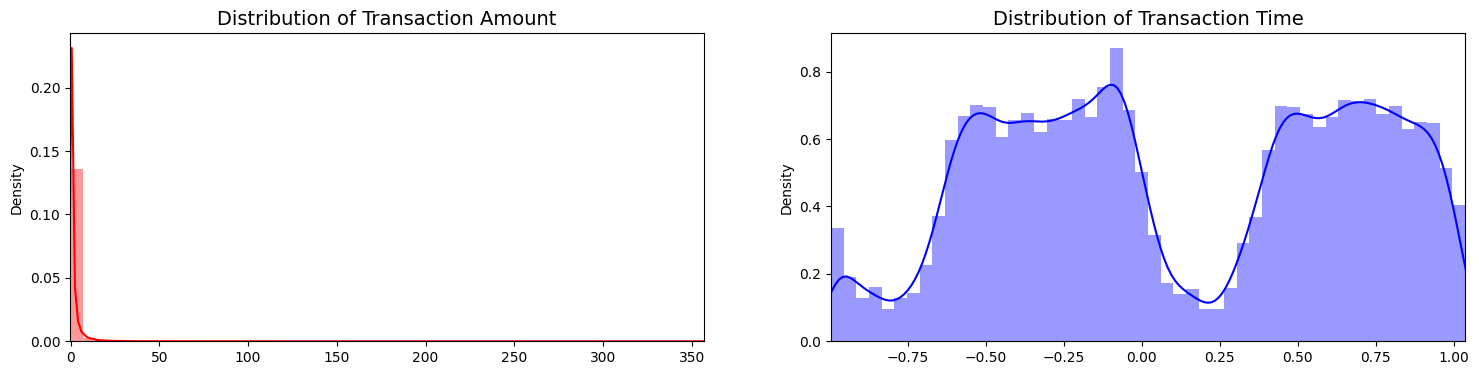

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['scaled_amount'].values
sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

time_val = df['scaled_time'].values
sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

By seeing the distributions we get an idea of how skewed are the two features. There are techniques that can help the distributions be less skewed, but we will skip this step for now.

## Data Preparation for Model Training
<a id="split"></a>

**Class distribution check**

In [15]:
print('Frauds:', round(df['Class'].value_counts()[1]/len(df),3))
print('No Frauds:', round(df['Class'].value_counts()[0]/len(df) ,3))

Frauds: 0.002
No Frauds: 0.998


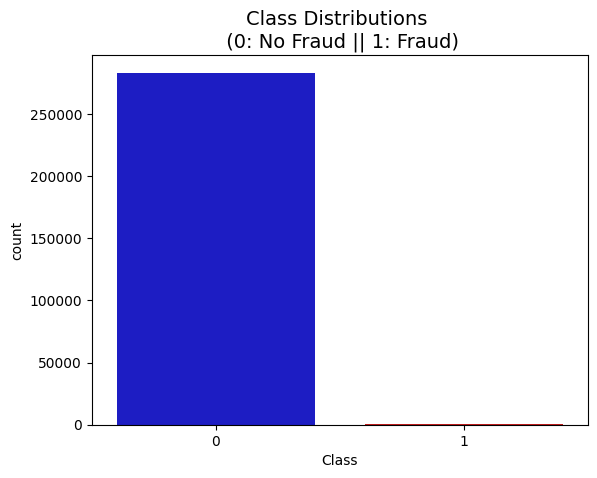

In [17]:
# visualize the distribution
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14);

**Note:**  Notice how imbalanced is the dataset! Most of the transactions are non-fraud. If we use this dataframe to train our predictive models, our models will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud! We will balance our training data in the later step.

**Split data into training and testing sets**

Before balancing the dataset, we will first split it into training and testing sets. We will balance the training dataset but will keep this testing set. The goal is to fit the model with a balanced training set (in order for predictive models to learn the patterns that could distinguish between fraud and non-fraud samples), and test it on the original testing set (which represents the real data distribution).

In [18]:
from sklearn.model_selection import ShuffleSplit

# randomly sample 80% as training and 20% as testing
ss = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)
train_idx, test_idx = next(ss.split(np.arange(df.shape[0])))

df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

In [19]:
# Verify that both the train and test dataset have similar label distributions
ct_train = Counter(df_train['Class'])
ct_test = Counter(df_test['Class'])

print("Training data: %.3f fraud, %.3f non-fraud" % (ct_train[0]/df_train.shape[0], ct_train[1]/df_train.shape[0]))
print("Testing data: %.3f fraud, %.3f non-fraud" % (ct_test[0]/df_test.shape[0], ct_test[1]/df_test.shape[0]))

Training data: 0.998 fraud, 0.002 non-fraud
Testing data: 0.998 fraud, 0.002 non-fraud


**Create a balanced training dataset**

The training dataset is heavily imbalanced regarding Fraud and Non-Fraud! We need to create a subsample of the training dataset that has a balanced amount of samples that are Fraud and Non-Fraud (by randomly undersample the Non-Fraud transactions and make it equal to the number of Fraud transactions). With the balanced dataset, the model could better understand patterns that determine whether a transaction is fraud or not.

In [20]:
# shuffle the data before creating the subsamples
df_shuffled = df_train.sample(frac=1)

# amount of fraud classes 492 rows.
df_fraud = df_shuffled.loc[df['Class'] == 1]
df_non_fraud = df_shuffled.loc[df['Class'] == 0][:df_fraud.shape[0]]

df_conct = pd.concat([df_fraud, df_non_fraud])

# Shuffle the dataframe
df_train_balanced = df_conct.sample(frac=1, random_state=42)

In [21]:
# the resulting dataframe has a balanced distribution of fraud and non-fraud
Counter(df_train_balanced['Class'])

Counter({0: 386, 1: 386})

In [26]:
# create feature matrix
X_train = df_train_balanced.drop('Class', axis=1)
y_train = df_train_balanced['Class']

X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

**Correlation matrix of the balanced dataset**

Correlation matrix is an important way to understand (1) features that are highly correlated (multicollinearity) and (2) features influence heavily for determine a fraud transaction.

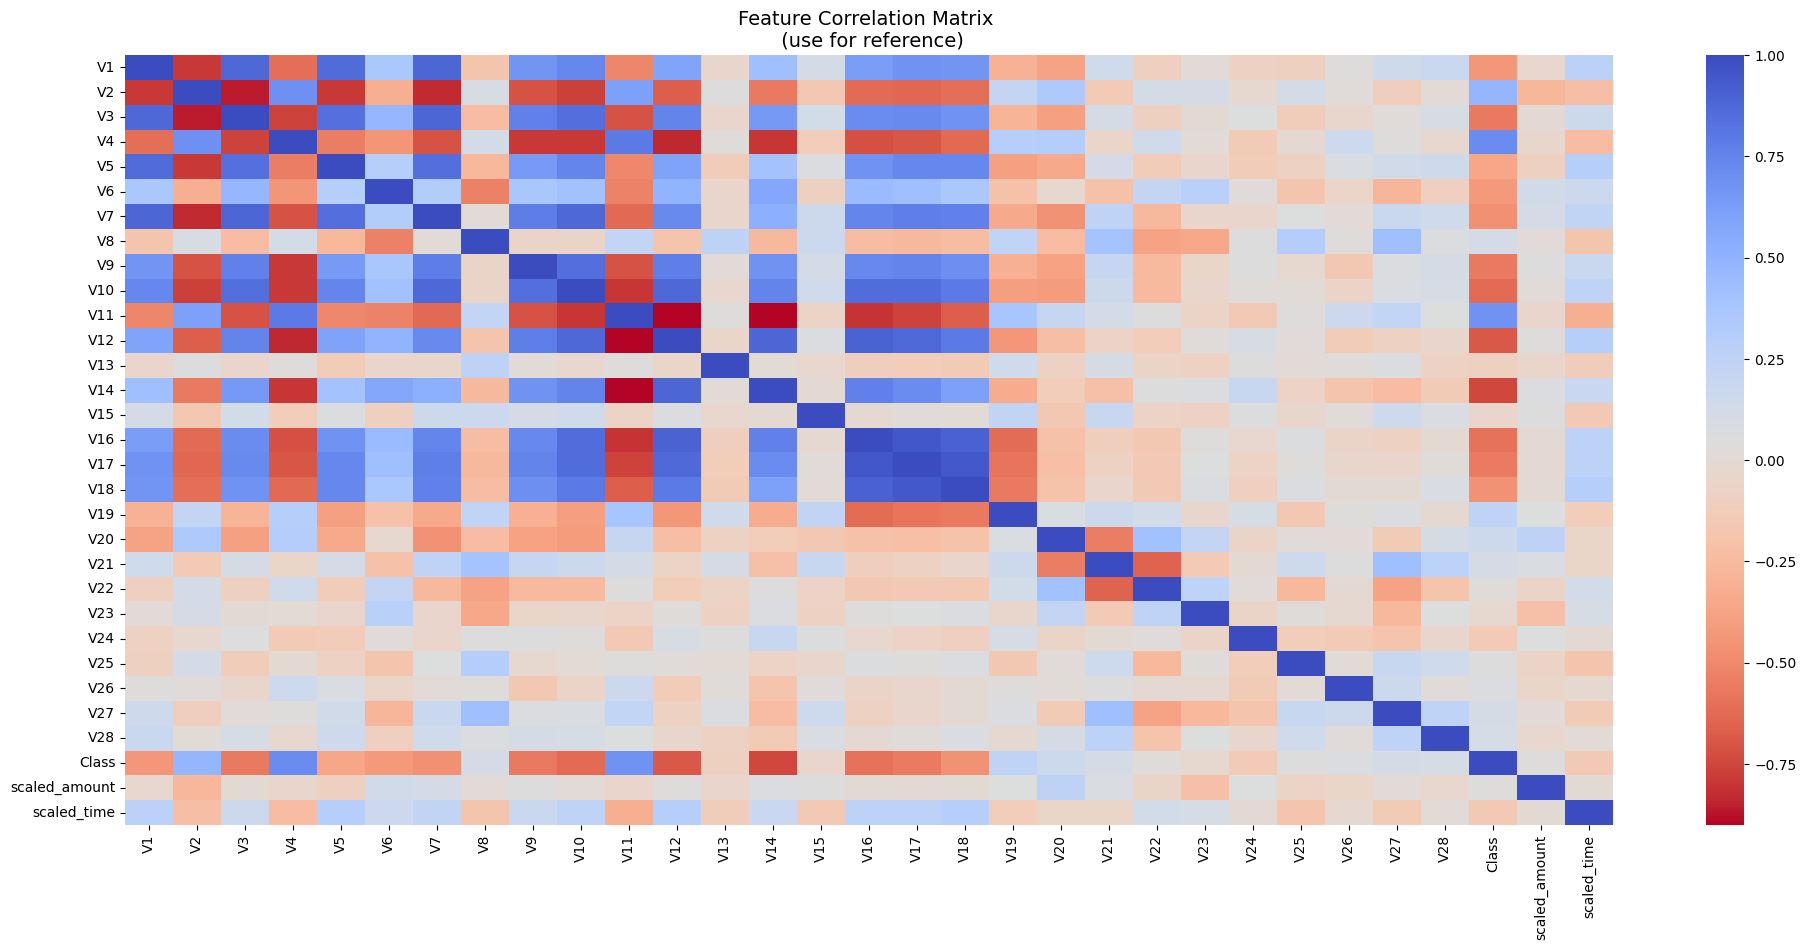

In [22]:
plt.figure(figsize=(24,10))
sub_sample_corr = df_train_balanced.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Feature Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

**Observations from correlation matrix:**
    
- V4, V11, V2, and V19 are highly correlated with fraud transaction.
- V14, V12, V10, and V16 are highly correlated with non-fraud transaction

We will use boxplots to have a better understanding of the distribution of these features in Fraud and Non-Fraud transactions.

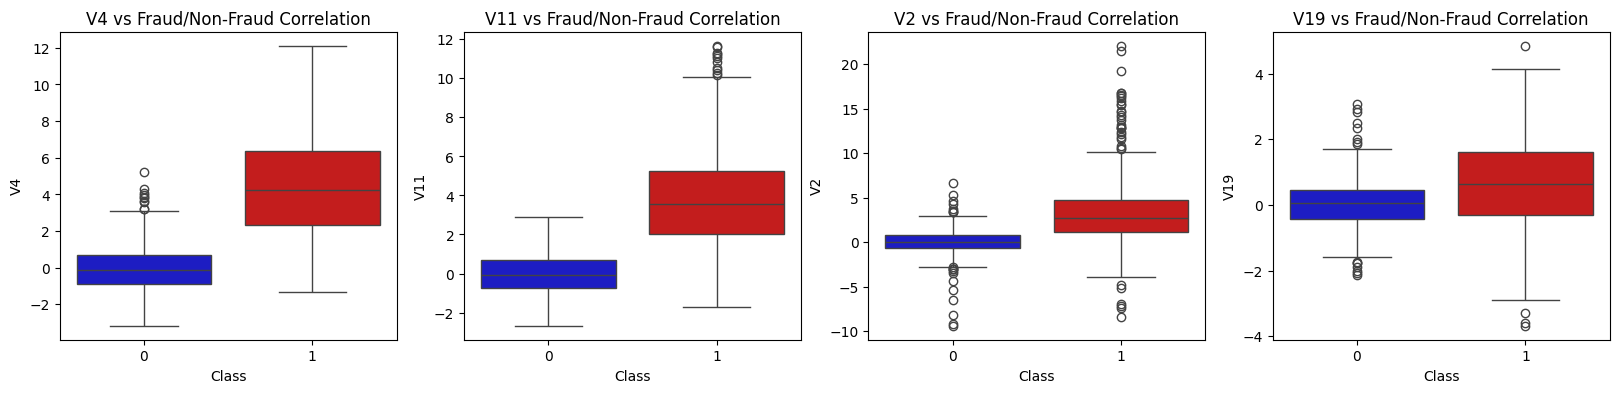

In [23]:
# Positive correlations (The higher the feature value, the more likely it will be a fraud transaction)

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V4", data=df_train_balanced, palette=colors, ax=axes[0])
axes[0].set_title('V4 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V11", data=df_train_balanced, palette=colors, ax=axes[1])
axes[1].set_title('V11 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V2", data=df_train_balanced, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V19", data=df_train_balanced, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Fraud/Non-Fraud Correlation')

plt.show()

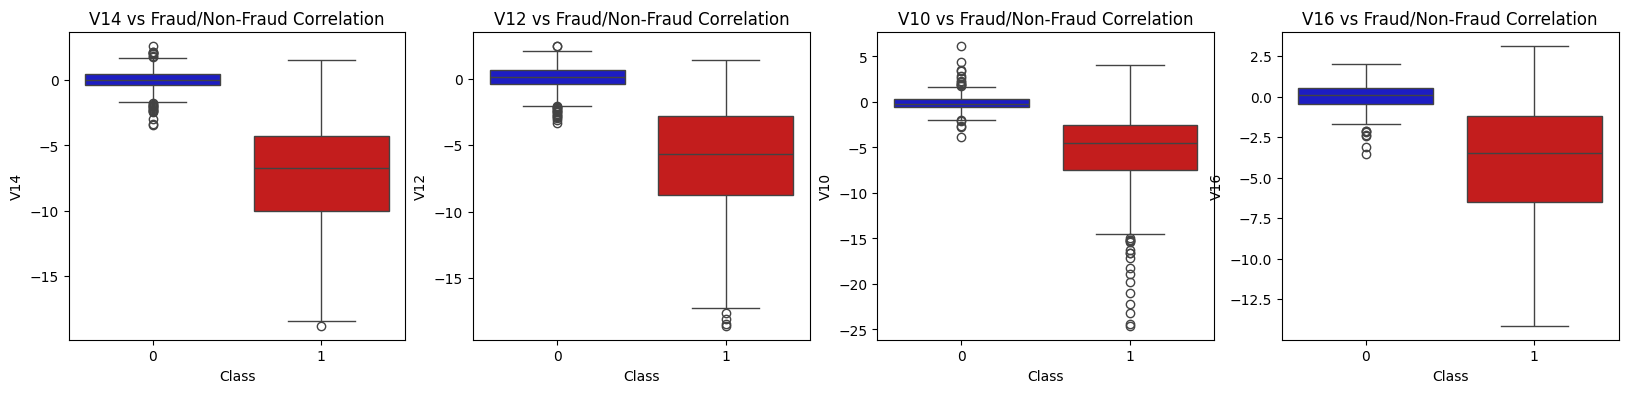

In [24]:
# Negative Correlations (The lower the feature value, the more likely it will be a fraud transaction)

f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V14", data=df_train_balanced, palette=colors, ax=axes[0])
axes[0].set_title('V14 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V12", data=df_train_balanced, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V10", data=df_train_balanced, palette=colors, ax=axes[2])
axes[2].set_title('V10 vs Fraud/Non-Fraud Correlation')

sns.boxplot(x="Class", y="V16", data=df_train_balanced, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Fraud/Non-Fraud Correlation')

plt.show()

## Unsupervised learning
<a id="unsupervised"></a>
In this section, we will apply three dimension reduction techniques (TSNE, PCA, TruncatedSVD) to reduce the original feature representation from 30 dimensions to 2 dimensions. Then we will visualize the training data in a 2D space and check if Fraud transactions automatically fall into the same cluster in the 2D space.

**Dimension reduction**

In [27]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_train.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.7 s
PCA took 0.012 s
Truncated SVD took 0.0081 s


**Data visualization and clustering in reduced dimensions**

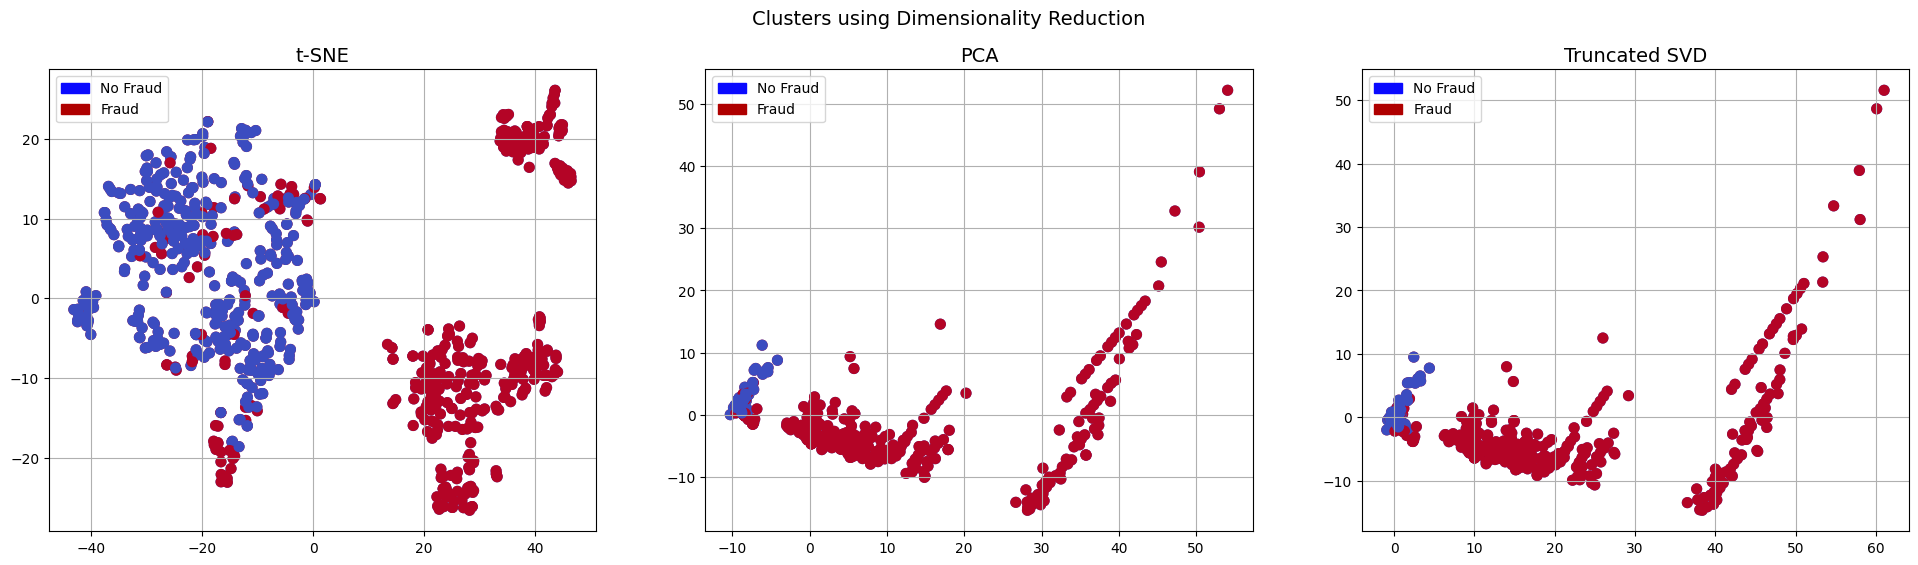

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

**Discussion**

After dimension reduction with the three techniques, Fraud and Non-Fraud transactions almost fall into separate clusters, which gives us an indication that further predictive models will perform pretty well in separating Fraud from Non-Fraud transactions (even with low dimensional feature representations).

## Supervised learning: classification
<a id="supervised"></a>
In this section, we will train a LogisticRegression classifier and a DecisionTree classifier to predict Fraud VS Non-Fraud, and then evaluate model performance using multiple metrics from classification report (precision, recall, f1, accuracy).

### A LogisticRegression classifier
- Fit a binary LogisticRegression classifier on the balanced training data and evaluate model performance on the testing data.
- We will interpret coefficients to understand features highly correlated with fraud.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

**Model training**

In [29]:
# train a binary classifier and predict for test data
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_test_pred = lr_clf.predict(X_test)

**Model evaluation**

In [30]:
# evaluate model performance on test data
print(classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.98     56659
       Fraud       0.04      0.92      0.08        87

    accuracy                           0.97     56746
   macro avg       0.52      0.94      0.53     56746
weighted avg       1.00      0.97      0.98     56746



**Model interpretation**

In [31]:
# Interpret features correlated with Fraud and Non-Fraud transactions
df_coef = pd.DataFrame({'features':lr_clf.feature_names_in_, 'coefficients':np.round(lr_clf.coef_[0],3)})

print("Top features that are correlated with Fraud:")
display(df_coef.sort_values(['coefficients'], ascending=False).iloc[:10])

print("\nTop features that are correlated with Non-Fraud:")
display(df_coef.sort_values(['coefficients'], ascending=True).iloc[:10])

Top features that are correlated with Fraud:


,features,coefficients
3,V4,0.830
26,V27,0.696
27,V28,0.619
21,V22,0.534
22,V23,0.481
10,V11,0.252
6,V7,0.159
4,V5,0.147
28,scaled_amount,0.128
18,V19,0.113



Top features that are correlated with Non-Fraud:


,features,coefficients
13,V14,-1.200
11,V12,-0.832
7,V8,-0.757
19,V20,-0.725
16,V17,-0.675
9,V10,-0.635
29,scaled_time,-0.546
15,V16,-0.443
20,V21,-0.373
12,V13,-0.297


**Discussion**

Based on feature coefficients from the LogisticRegression model,
- Features V4, V19, V27, V28, ect are highly correlated with Fraud transactions.
- Features V14, V20, V12, V8, etc are highly correlated with Non-Fraud transactions.

Most of these correlations are in line with our preliminary analysis in correlation matrix.

It's worth noting that "scaled_amount" is correlated with Fraud transaction while "scaled_time" is correlated with Non-Fraud transaction. **Could you explain this relationship with your expertise in computer security?**


### A DecisionTree classifier

- Fit a binary DecisionTree classifier on the balanced training data and evaluate model performance on the testing data.
- We will visualize the resulting tree and interpret feature importance in the context of Fraud transaction.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

**Model training**

In [32]:
# Fit a DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

**Model evaluation**

In [33]:
# evaluate model performance on test data
y_test_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.91      0.95     56659
       Fraud       0.01      0.92      0.03        87

    accuracy                           0.91     56746
   macro avg       0.51      0.91      0.49     56746
weighted avg       1.00      0.91      0.95     56746



**Decision Tree model visualization**

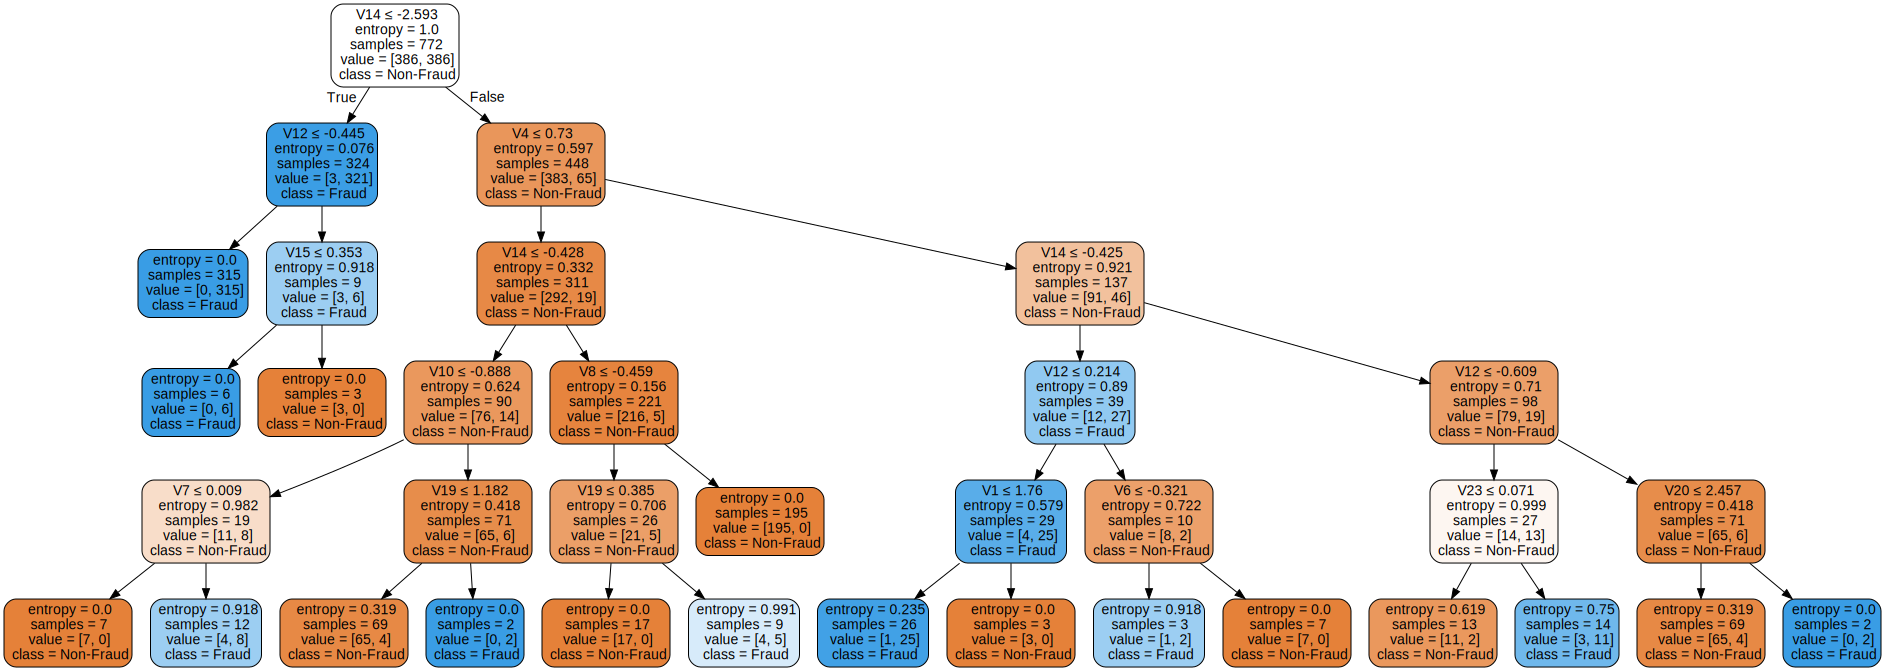

In [34]:
# Plot the fitted DecisionTreeClassifier. Check: https://scikit-learn.org/stable/modules/tree.html

import graphviz

dtc_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=df_train_balanced.drop('Class',axis=1).columns,
                                class_names=['Non-Fraud','Fraud'],
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dtc_data)
graph

**Model interpretation**

In [35]:
# get feature importance
features = df_train_balanced.drop('Class', axis=1).columns
importance = np.round(dt_clf.feature_importances_,2)

# Create pandas dataframe of feature and correpsonding importance
df_importance = pd.DataFrame([features, importance]).T
df_importance.rename(columns={0: 'feature', 1:'importance'}, inplace=True)

# Sort descendingly based on importance
df_importance.sort_values(['importance'], ascending=False, inplace=True)

# Show dataframe
df_importance[df_importance['importance']>0].reset_index(drop=True)

,feature,importance
0,V14,0.76
1,V4,0.06
2,V12,0.06
3,V19,0.03
4,V1,0.02
5,V8,0.02
6,V10,0.01
7,V23,0.01
8,V15,0.01
9,V20,0.01


**Discussion**

Based on feature importance from the DecisionTree model, features *V14, V4, V8, V12, scaled_amount, scaled_time, V19, and V17* are the top-10 features that highly correlate with fraud transactions.

This result is also consistent with our preliminary analysis in correlation matrix.

It's worth noting that the tree model learns "scaled_amount" is more important than "scaled_time". **Could you explain this result with your expertise in computer security?**

**Compare LogisticRegression and DecisionTree models**

When comparing the classification report for the two models:
- both show better performance for predicting Non-Fraud than predicting Fraud, this is mainly due to the data imbalance in the testing set
- both models have high recall and low precision for Fraud prediction, which is also expected given the imbalanced data distribution
- LogisticRegression performs better than DecisionTree classifier in terms of prediction accuracy. The relative low performance of DecisionTree could be improved by increasing the *max_depth* during model training.

When interpreting feature importance from the two models, both models are consistent with preliminary analysis in correlation matrix. With evidence from different analysis, we are more confident of features that are predictive of Fraud.

## Conclusion

In this jupyter notebook, we provide a machine learning workflow for credit card fraud detection.
- We begin with an exploratory data analysis to gain insights into the dataset.
- Next, we split the data into training and testing sets, and balance the training data with the undersampling technique.
- We then applied unsupervised learning techniques to perform dimension reduction and visualize the data in a lower-dimensional feature space. We observed separate clusters of Fraud and Non-Fraud transactions.
- Additionally, we employed supervised learning techniques (LogisticRegression and DecisionTree classifiers) to model the relationship between 30 numerical features with the target variable "Class" (indicating Fraud or Non-Fraud). Both classifiers demonstrate satisfactory performance.
- Finally, we leverage the properties of the two classifiers to identify features that contribute the most to distinguishing between Fraud and Non-Fraud transactions, as well as features that are most predictive of fraudulent activities.

**For further improvements**, please consider the following options:
- Collecting more Fraud transaction data: the current dataset is heavily unbalanced and we use undersampling to balance it. The balanced data size is limited by the number of Fraud transactions. Collecting addtional Fraud transaction data and creating a larger dataset could potentially improve model performance.
- Fine-tuning model parameters: the current classifiers are trained with default parameter settings. Applying parameter tunning techniques to identify the optimal parameter settings for the given dataset could provide better model performance.
- The current dataset does not provide original feature names due to confidentiality issues. If given the feature names, we could better interpret factors that are predictive of Fraud transactions and propose additional features (e.g., historical purchasing behavior) to improve model performance.